# Graph Convolutional Network

My attempt at building a simple 2-layer Graph Convolution Neural Network for graph classification with Pytorch.

Utilises the definitions and architecture outlined in _Kipf & Welling, [Semi-Supervised Classification with Graph Convolutional Networks](http://arxiv.org/abs/1609.02907) (ICLR 2017)_.

## Imports and dataset

In [73]:
!pip install dgl
!pip install tqdm
# !pip install -U networkx

In [0]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [0]:
N_classes = 8
data_size = 100

def one_hot(idx):
    """
    Method to one hot encode class number

    Params:
        idx: class number / index to assign to 1
    Returns:
        vec: tensor of length N_classes, containing all 0s except the position of idx
    """
    vec = torch.zeros(N_classes)
    vec[idx] = 1
    return vec

def un_one_hot(vec):
    """
    Method to get the class/index given a one hot encoded vector
    """
    return int(torch.where(vec == 1)[0])

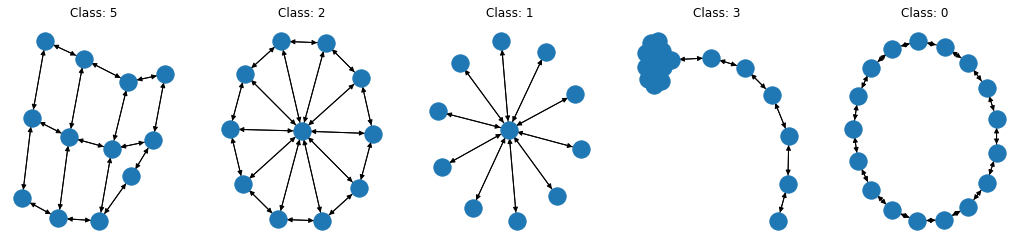

In [49]:
gcdataset = MiniGCDataset(data_size,10,20)

# convert DGLgraph to networkx
# each entry in dataset: (networkx graph, label)
dataset = []
for i in np.arange(data_size):
    graph, label = gcdataset[i]
    label = one_hot(label)
    graph = graph.to_networkx()
    node_attrs = {i: list(torch.randn(2)) for i in np.arange(graph.number_of_nodes())}
    nx.set_node_attributes(graph, node_attrs, 'name') # add random 2-length vector as node attribute for all nodes (attribute 'name')
    dataset.append( (graph, label) )
    
# show samples from dataset
plt.figure(figsize=(18,4))
for i, g in enumerate(np.random.randint(0, data_size, 5)):
    graph, label = dataset[g]
    label = un_one_hot(label)
    plt.subplot(1,5,i+1)
    nx.draw(graph)
    plt.title('Class: {}'.format(label));

## Graph convolution

A graph convolution is defined as follows (eqn. 8 in _Kipf & Welling_). 

For a signal $X \in \mathbb{R}^{N \times C}$ with $N$ nodes and $C$ input channels, and $F$ filters or feature maps:
$$ Z = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} X \Theta ,$$

where:
* $Z \in \mathbb{R}^{N \times F}$ is the convolved signal matrix
* $\Theta \in \mathbb{R}^{C \times F}$ is a matrix of filter parameters
* $\tilde{A} = A + I_N$ is the adjacency matrix A with added self-connections
* $\tilde{D} = \sum_j \tilde{A}_{ij}$ is the degree matrix of the new adjacency matrix

Here a _renormalisation trick_ is performed, such that the rescaled, normalised graph Laplacian with self-loops is expressed by $\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}}$.

In [0]:
def get_feature_matrix(g):
    """
    Method to gather a graph's node features as matrix.

    Params:
        g: networkx graph
    Returns:
        X: A tensor of size N x C, where N = no. of nodes & C = no. of channels.
    """
    return torch.Tensor(list(nx.get_node_attributes(g, 'name').values()))

### Example graph convolution

In [51]:
g = dataset[0][0]
N = g.number_of_nodes()
X = get_feature_matrix(g)

ϴ = nn.Linear(in_features=2, out_features=3)
A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

A_tilde = A + torch.eye(N) # add self-connections
D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

Z = ϴ(torch.mm(L_tilde, X))
Z

tensor([[ 0.4922, -0.0734, -0.0965],
        [ 0.4288, -0.1256, -0.1882],
        [ 0.3998,  0.3128, -0.3765],
        [ 0.3776,  0.0264, -0.3237],
        [ 0.4338, -0.1161, -0.1827],
        [ 0.4097, -0.3245, -0.1578],
        [ 0.4252, -0.1095, -0.1995],
        [ 0.3318,  0.1299, -0.4347],
        [ 0.3095,  0.0299, -0.4411],
        [ 0.2462,  0.2403, -0.6156],
        [ 0.2644,  0.3798, -0.6288],
        [ 0.3248,  0.8871, -0.6864],
        [ 0.4235,  0.6546, -0.4443],
        [ 0.5060,  0.4706, -0.2452],
        [ 0.5209, -0.1668, -0.0179]], grad_fn=<AddmmBackward>)

## GCN torch Layer

In [0]:
class GCNLayer(nn.Module):
    """
    Torch Module for a single graph convolution.
    """

    def __init__(self, C, F):
        """
        Params:
            C: No. of channels in input signal. i.e. length of node feature vector.
            F: No. of filters/ feature banks.
        """
        super(GCNLayer, self).__init__() #idk what this does?
        self.ϴ = nn.Linear(in_features=C, out_features=F)
        
    def forward(self, g, X):
        """
        Params:
            g: input graph (networkx)
            X: feature matrix / signal from prev layer. Use get_feature_matrix(g) for first network layer.
        """
        N = g.number_of_nodes()
        A = torch.Tensor( nx.adjacency_matrix(g).todense() ) # A = dense adj. matrix as Tensor

        A_tilde = A + torch.eye(N) # add self-connections
        D_tilde = torch.sum(A_tilde, 1) # degree matrix of A_tilde
        D_tilde_half = (D_tilde + 1e-5) ** (-0.5)
        L_tilde = D_tilde_half * A * D_tilde_half # rescaled normalised graph Laplacian

        Z = self.ϴ(torch.mm(L_tilde, X))
        return Z

### Example GCN layer

In [53]:
gcn = GCNLayer(C=2, F=5)
gcn(g, get_feature_matrix(g))

tensor([[-0.1724,  0.4643,  0.4708,  0.3696, -0.9822],
        [-0.1904,  0.3190,  0.2327,  0.4743, -0.8462],
        [ 0.0836,  0.1392, -0.0638,  0.7081, -0.3379],
        [-0.0863,  0.1540, -0.0383,  0.6369, -0.5490],
        [-0.1857,  0.3291,  0.2492,  0.4682, -0.8517],
        [-0.3076,  0.3203,  0.2355,  0.4320, -0.9822],
        [-0.1798,  0.3061,  0.2114,  0.4879, -0.8201],
        [-0.0132,  0.0144, -0.2676,  0.7692, -0.3145],
        [-0.0693, -0.0166, -0.3182,  0.7732, -0.3455],
        [ 0.0730, -0.2259, -0.6620,  0.9831,  0.0435],
        [ 0.1541, -0.2149, -0.6445,  1.0032,  0.1247],
        [ 0.4506, -0.1889, -0.6037,  1.0878,  0.4371],
        [ 0.2870,  0.1143, -0.1058,  0.7988, -0.0774],
        [ 0.1566,  0.3651,  0.3061,  0.5613, -0.4975],
        [-0.2357,  0.5589,  0.6261,  0.2751, -1.1568]],
       grad_fn=<AddmmBackward>)

## Network for classsification

In [0]:
class Classifier(nn.Module):
    """
    2 layer Graph CNN for graph classification
    """

    def __init__(self, c, f_in, f_hidden, n_classes):
        """
        Params:
            c: No. of channels. (Length of node feature vector)
            f_in: No. of filters in input layer
            f_hidden: No. of filters in hidden layer
            n_classes: No. of output classes
        """
        super(Classifier, self).__init__()

        self.gcn1 = GCNLayer(C=c, F=f_in)
        self.gcn2 = GCNLayer(C=f_in, F=f_hidden)

        self.classify = nn.Linear(f_hidden, n_classes)


    def forward(self, g):
        """
        Params:
            g: input graph (networkx)
        Returns:
            Z: classifier output
        """
        Z = F.relu(self.gcn1(g, get_feature_matrix(g)))
        Z = F.relu(self.gcn2(g, Z))
        Z = self.classify(Z.mean(axis=0)) # mean reduce, row-wise
        Z = F.softmax(Z, dim=0)
        return Z

In [56]:
model = Classifier(c=2, f_in=7, f_hidden=5, n_classes=8)
model

Classifier(
  (gcn1): GCNLayer(
    (Θ): Linear(in_features=2, out_features=7, bias=True)
  )
  (gcn2): GCNLayer(
    (Θ): Linear(in_features=7, out_features=5, bias=True)
  )
  (classify): Linear(in_features=5, out_features=8, bias=True)
)

In [57]:
g = dataset[0][0]
print(g.number_of_nodes())
predict = model(g)
predict

15


tensor([0.1936, 0.1317, 0.1733, 0.1207, 0.0958, 0.0708, 0.1082, 0.1059],
       grad_fn=<SoftmaxBackward>)

## Training

100%|██████████| 100/100 [00:23<00:00,  4.10it/s]


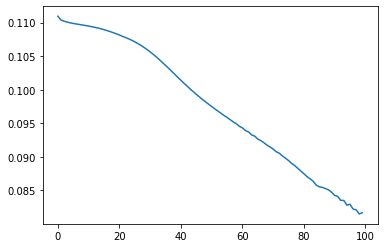

In [82]:
model = Classifier(c=2, f_in=7, f_hidden=5, n_classes=8)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

epoch_losses = []
for epoch in tqdm(range(data_size), desc='Training'):
    epoch_loss = 0
    for iter, (graph, label) in enumerate(dataset):
        prediction = model(graph)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()

    epoch_loss /= (iter + 1)
    # print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.xlabel('Training examples')
plt.ylabel('MSE')